# CIFAR10 Image Classification Using TensorFlow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tqdm import tqdm
import sys
import os
import cv2
from time import time

# 第一章 CIFAR10 上手

## 1. CIFAR10 数据集概述

- 总计 60000 张图片。其中 50000 张用于训练，10000 张用于测试。
- 所有图片的尺寸统一为 32 x 32 x 3
- 图片的内容标签分为 10 类，每张图片的标签唯一。
- 每一类图片的个数都是 6000 张。 

## 2. CIFAR10 数据集分析

- 图片尺寸全部统一，因此无需对图片尺寸进行 resize。
- 每一个标签的数据量相等，因此整个数据集是平衡的（Balanced），不存在非平衡数据集的训练问题。
- 数据集很庞大，有六万张照片，不存在小数据集训练的过拟合问题。

## 3. CIFAR10 数据集格式

- 压缩包里含有 6 个 Pickle 文件，其中 5 个 `data_batch` 是训练集，单独一个 `test_batch` 是测试集。
- 用 `pickle.load()` 将所有文件中的数据都读入内存


- 每个 Pickle 文件都含有 10000 张图片及其展示的内容标签。Pickle 文件所包含的对象是一个词典，该词典有如下4个键：
    - data：图像像素数据，np.array 类型
    - labels：图像内容标签，list 类型
    - filenames：原始图像的文件名（目前用不上）
    - batch_label：数据所属的训练集编号（没什么用）
    
    
- data 是一个尺寸为 (10000, 3072) 的 Numpy 数组
    - 每一行是一张图片的所有像素，长度为3072
    - 每张图片的尺寸是32x32=1024，其三个颜色通道串联接在一起，即 1024,1024,1024
    - 需要将每张尺寸为 (1, 3072) 的图片还原为正常的图像尺寸 (32, 32, 3)
    - 由于考虑到目前第一维只能是颜色通道，因此应该先将其 reshape(3, 32, 32), 再用 transpose 把颜色通道交换至最后一个维度。
    

- labels 是一个长度为 10000 的 list，表示图像的实际内容类别，取值为 [0, 9]，其涵义如下：
    - 0 = airplane										
    - 1 = automobile										
    - 2 = bird										
    - 3 = cat										
    - 4 = deer										
    - 5 = dog										
    - 6 = frog										
    - 7 = horse										
    - 8 = ship										
    - 9 = truck

In [63]:
path = 'cifar-10-batches-py//'
p = pickle.load(open(path + 'data_batch_1', 'rb'), encoding='bytes')

In [64]:
p.keys()

dict_keys([b'data', b'labels', b'filenames', b'batch_label'])

In [65]:
data = p[b'data']
labels = p[b'labels']
type(data), type(labels)

(numpy.ndarray, list)

In [66]:
data.shape, len(lables)

((10000, 3072), 10000)

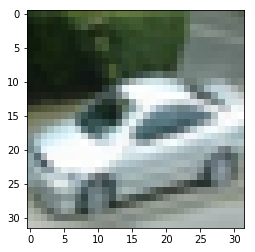

(32, 32, 3)

In [80]:
# 看第一张图片的样子
pic = np.random.choice(range(10000))
img = data[pic].reshape(3, 32, 32)    # 先以颜色通道为大，分离出三个颜色通道
img = np.transpose(img, (1, 2, 0))    # 然后将颜色通道维度从原来的第0维换至最后一维
plt.imshow(img, cmap='gray')
plt.show()
img.shape

## 4. CIFAR10 数据集预处理

- 合并全部 50000 张训练图片及其标签
- 将像素灰度值归一化
- 将标签进行 One-Hot 编码，以供后期使用 Softmax 进行预测
- 导出经过预处理后的训练数据为 Pickle 文件，方便以后直接调用

### 4.1 合并全部 50000 张训练图片及其标签

In [115]:
# 先申请一块完整的内存，然后再用循环慢慢将这块内存填满，这样比不断追加的方案内存效率高得多
X = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
Y = []
path = 'cifar-10-batches-py//'

for i in range(1, 6):
    p = pickle.load(open(path + 'data_batch_' + str(i), 'rb'), encoding='bytes')
    data = p[b'data']
    labels = p[b'labels']
    data = data.reshape(10000, 3, 32, 32)
    data = np.transpose(data, (0, 2, 3, 1))
    
    # Append data
    X[(i - 1) * 10000 : i * 10000] = data
    
    # Concat labels
    Y += labels

In [116]:
X.shape, len(Y)

((50000, 32, 32, 3), 50000)

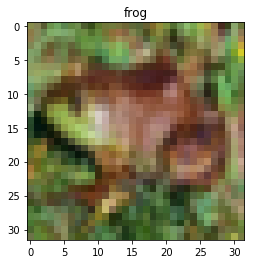

In [155]:
# Check a random img and it's label
mapping = {0:'airplane', 
           1:'automobile', 
           2:'bird', 
           3:'cat', 
           4:'deer', 
           5:'dog', 
           6:'frog', 
           7:'horse', 
           8:'ship', 
           9:'truck'}
rid = np.random.choice(range(50000))
img = X_norm[rid]
l = Y[rid]
plt.imshow(img, cmap='gray')
plt.title(mapping[l])
plt.show()

### 4.2 对像素灰度值进行归一化

In [183]:
X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
X_norm = X_norm.astype(np.float32)

In [184]:
# 对比归一化后同一张图片相同区域像素点的取值变化
X[0, :5, :5, 0]

array([[ 59,  43,  50,  68,  98],
       [ 16,   0,  18,  51,  88],
       [ 25,  16,  49,  83, 110],
       [ 33,  38,  87, 106, 115],
       [ 50,  59, 102, 127, 124]], dtype=uint8)

In [192]:
X_norm[0, :5, :5, 0]

array([[ 0.23137255,  0.16862746,  0.19607843,  0.26666668,  0.38431373],
       [ 0.0627451 ,  0.        ,  0.07058824,  0.2       ,  0.34509805],
       [ 0.09803922,  0.0627451 ,  0.19215687,  0.32549021,  0.43137255],
       [ 0.12941177,  0.14901961,  0.34117648,  0.41568628,  0.4509804 ],
       [ 0.19607843,  0.23137255,  0.40000001,  0.49803922,  0.48627451]], dtype=float32)

In [193]:
# 由于元素类型从 uint8 变成 float32，因此占用空间增大很多
sys.getsizeof(X)/1024/1024, sys.getsizeof(X_norm)/1024/1024

(146.48451232910156, 585.9376373291016)

### 4.3 对标签进行 One-Hot 编码

In [166]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
# 按照数字顺序进行映射，如果直接 fit_transform 的话映射顺序取决于样本中类型的出现顺序
lb.fit(range(10)) 
Y_onehot = lb.transform(Y)

In [172]:
type(Y_onehot), Y_onehot.shape, Y[0], Y_onehot[0]

(numpy.ndarray, (50000, 10), 6, array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

### 4.4 导出预处理后的训练数据

- 将训练数据输出为含有 4 个元素的 Tuple
    - 前两个是训练集图像及其标签，含有 45000 张图片
    - 后两个是验证集图像及其标签，含有 5000  张图片

In [194]:
pickle.dump((X_norm[:45000], Y_onehot[:45000], 
             X_norm[45000:], Y_onehot[45000:],), 
            open('CIFAR10 Preprocessed', 'wb'))

# 第二章 CIFAR10 模型训练

## 1. 载入预处理后的训练数据

In [3]:
X_train, Y_train, X_test, Y_test = pickle.load(open('CIFAR10 Preprocessed', mode='rb'))
print("X_train Dimension: ", X_train.shape)
print("Y_train Dimension", Y_train.shape)
print("X_test Dimension: ", X_test.shape)
print("Y_test Dimension", Y_test.shape)

X_train Dimension:  (45000, 32, 32, 3)
Y_train Dimension (45000, 10)
X_test Dimension:  (5000, 32, 32, 3)
Y_test Dimension (5000, 10)


## 2. 计算卷积层的输出尺寸

- 卷积层输出的矩阵尺寸由三个因素决定：
    - 输入矩阵尺寸
    - 卷积核尺寸
    - 步长
    

- 计算公式为

$$\mathrm{output = (input - kernel + 2 * padding) ~ / ~ stride + 1}$$

下面用指针的思路写了一个推测输出形状的函数，比计算公式好理解。

In [10]:
# 假设输入图片和卷积核的形状都是正方形
def get_output_shape(input_shape, kernel_shape, stride):
    j = kernel_shape - 1
    c = 0
    while j < input_shape:
        c += 1
        j += stride
    return c

# 假设图片尺寸为 32 x 32 x 3，卷积核尺寸为 3 x 3 x 3，步长为 2，卷积核个数 64
n_kernel = 64
input_shape = 32
output_shape = get_output_shape(32, 3, 2)
print('Input Shape = ', (input_shape, input_shape, 3))
print('Output Shape = ', (output_shape, output_shape, n_kernel))

Input Shape =  (32, 32, 3)
Output Shape =  (15, 15, 64)


## 3. 构造模型

- 模型由以下几层组合而成
    - **卷积层**：用卷积核与每个图像进行卷积计算，输出特征图（Feature map），图像的深度得到扩展。
    - **池化层**：挑选取值最大的像素点作为代表，主要意义是降维（降低图像尺寸）
    - **展开层**：将三维的图像数据拉直为一维向量，向量的每个元素被视为一个特征，方便送入全连接层。
    - **全连接层**：特征的非线性分类器，与 MLP 中的全链接层功能一样。

### tf.layers.conv2d
> tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer=None, bias_initializer=?, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, trainable=True, name=None, reuse=None)

### tf.nn.conv2d

> tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)

conv2d 是一个 operation，要求输入的 input 和 filter 本身都是 Tensor 类型的对象，因此需要先用 `tf.Variable` 定义这两个对象，并且对权重矩阵这个 Tensor 进行初始化才能调用 conv2d 函数。


In [11]:
def conv_layer(x, out_channel, k_size, stride, padding):
    in_channel = x.shape[3].value
    w = tf.Variable(tf.truncated_normal([k_size, k_size, in_channel, out_channel], mean=0, stddev=stddev))
    b = tf.Variable(tf.zeros(out_channel))
    x = tf.nn.conv2d(x, filter=w, strides=[1, stride, stride, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x


def pool_layer(x, k_size, stride, padding):
    return tf.nn.max_pool(x, ksize=[1, k_size, k_size, 1], strides=[1, stride, stride, 1], padding=padding)


def flatten_layer(x):
    dim = x.shape[1].value * x.shape[2].value * x.shape[3].value
    return tf.reshape(x, shape=[-1, dim])


def fc_layer(x, n_output):
    w = tf.Variable(tf.truncated_normal([x.shape[1].value, n_output], mean=0, stddev=stddev))
    b = tf.Variable(tf.zeros(n_output))
    x = tf.matmul(x, w)
    x = tf.add(x, b)
    x = tf.nn.relu(x)
    return x


def dropout_layer(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)


def output_layer(x, n_output):
    w = tf.Variable(tf.truncated_normal([x.shape[1].value, n_output], mean=0, stddev=stddev))
    b = tf.Variable(tf.zeros(n_output))
    x = tf.matmul(x, w)
    x = tf.add(x, b)
    x = tf.identity(x, name='logits')  # Rename
    return x

In [26]:
def create_model(x, keep_prob):
    x = conv_layer(x, 16, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = conv_layer(x, 32, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = conv_layer(x, 64, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = flatten_layer(x)
    x = fc_layer(x, 128)
    x = dropout_layer(x, keep_prob)
    x = output_layer(x, 10)   
    return x

## 4. 训练模型

### 4.1 建立计算图

In [27]:
epoch = 100
n_class = 10
batch_size = 256
stddev = 0.01
dropout = 0.5

tf.reset_default_graph()
x_input   = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x_input')
y_true    = tf.placeholder(tf.float32, shape=(None, n_class), name='y_true')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

y_pred = create_model(x_input, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))    
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### 4.2 数据生成器

In [9]:
def get_batch(x, y, batch_size):
    for start in range(0, len(x), batch_size):
        end = min(start + batch_size, len(x))
        yield x[start:end], y[start:end]

### 4.3 用 Session 执行运算图

In [28]:
history = {}
history['acc'] = []
history['val_acc'] = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    # 可视化整个网络结构的视图，通过 TensorBoard 查看
    tf.summary.FileWriter('./graphs', session.graph)
    session.run(tf.global_variables_initializer())
    for i in range(epoch):
        # 将训练集按 batch_size 切分为很多 batch，每个 batch 用于更新一次模型参数
        for X_batch, Y_batch in get_batch(X_train, Y_train, batch_size):
            session.run(optimizer, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:dropout})
        
        # 本轮训练集（45000张图片）最后一个 batch 的损失值
        loss = session.run(cost, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
        
        # 本轮训练后的模型用于训练集的最后一个 batch 的准确率
        acc = session.run(accuracy, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
        history['acc'].append(acc)
        
        # 本轮训练后的模型用于验证集（5000张图片）的准确率
        val_acc = session.run(accuracy, feed_dict={x_input:X_test, y_true:Y_test, keep_prob:1})
        history['val_acc'].append(val_acc)
        
        print("Epoch =", i, "    train_loss =", loss, 
              "     train_acc =", round(acc * 100, 2), "%", 
              "     validation_acc =", round(val_acc * 100, 2), "%")

    saver = tf.train.Saver()
    save_path = saver.save(session, '.\michael')

Epoch = 0     train_loss = 1.98898      train_acc = 25.0 %      validation_acc = 27.42 %
Epoch = 1     train_loss = 1.80629      train_acc = 33.5 %      validation_acc = 34.16 %
Epoch = 2     train_loss = 1.67055      train_acc = 41.5 %      validation_acc = 37.08 %
Epoch = 3     train_loss = 1.61715      train_acc = 43.5 %      validation_acc = 38.92 %
Epoch = 4     train_loss = 1.5671      train_acc = 43.0 %      validation_acc = 40.76 %
Epoch = 5     train_loss = 1.51051      train_acc = 45.0 %      validation_acc = 42.7 %
Epoch = 6     train_loss = 1.49546      train_acc = 43.5 %      validation_acc = 44.52 %
Epoch = 7     train_loss = 1.47247      train_acc = 45.5 %      validation_acc = 45.62 %
Epoch = 8     train_loss = 1.43555      train_acc = 47.5 %      validation_acc = 47.2 %
Epoch = 9     train_loss = 1.40665      train_acc = 49.5 %      validation_acc = 48.76 %
Epoch = 10     train_loss = 1.38492      train_acc = 49.5 %      validation_acc = 50.28 %
Epoch = 11     train_lo

### 可以看到，采用三层卷积加池化的模型，可以在训练100代后达到将近 70% 的准确率。

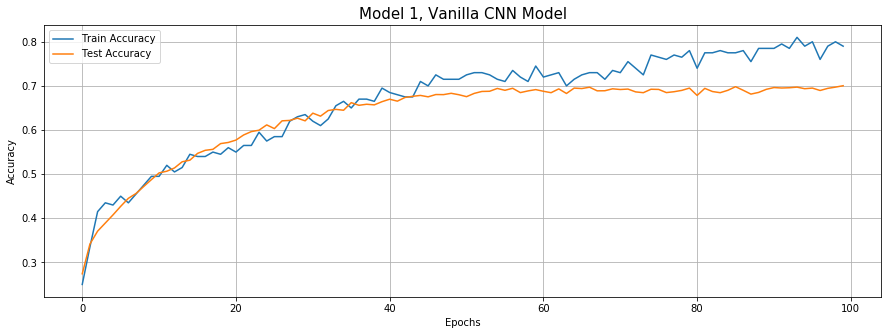

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(range(100), history['acc'], label='Train Accuracy')
plt.plot(range(100), history['val_acc'], label='Test Accuracy')
plt.title('Model 1, Vanilla CNN Model', size=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 5. 修改模型

下面使用 TensorFlow 所提供的封装好的各层函数重新实现同样结构的模型。

不同的是这里使用 Xavier 方式初始化权重矩阵，L2正则，以及 Batch Norm.

In [38]:
def create_model2(x, keep_prob):
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 128, activation_fn=tf.nn.relu)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=None)
    return x

In [39]:
tf.reset_default_graph()
x_input   = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x_input')
y_true    = tf.placeholder(tf.float32, shape=(None, n_class), name='y_true')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

y_pred = create_model2(x_input, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))    
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

history2 = {}
history2['acc'] = []
history2['val_acc'] = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    # 可视化整个网络结构的视图，通过 TensorBoard 查看
    tf.summary.FileWriter('./graphs', session.graph)
    session.run(tf.global_variables_initializer())
    for i in range(epoch):
        # 将训练集按 batch_size 切分为很多 batch，每个 batch 用于更新一次模型参数
        for X_batch, Y_batch in get_batch(X_train, Y_train, batch_size):
            session.run(optimizer, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:dropout})
        
        # 本轮训练集（45000张图片）最后一个 batch 的损失值
        loss = session.run(cost, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
        
        # 本轮训练后的模型用于训练集的最后一个 batch 的准确率
        acc = session.run(accuracy, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
        history2['acc'].append(acc)
        
        # 本轮训练后的模型用于验证集（5000张图片）的准确率
        val_acc = session.run(accuracy, feed_dict={x_input:X_test, y_true:Y_test, keep_prob:1})
        history2['val_acc'].append(val_acc)
        
        print("Epoch =", i, "    train_loss =", loss, 
              "     train_acc =", round(acc * 100, 2), "%", 
              "     validation_acc =", round(val_acc * 100, 2), "%")

Epoch = 0     train_loss = 1.44383      train_acc = 49.0 %      validation_acc = 47.04 %
Epoch = 1     train_loss = 1.28605      train_acc = 53.0 %      validation_acc = 54.46 %
Epoch = 2     train_loss = 1.19024      train_acc = 58.5 %      validation_acc = 58.68 %
Epoch = 3     train_loss = 1.09683      train_acc = 61.5 %      validation_acc = 61.14 %
Epoch = 4     train_loss = 1.0339      train_acc = 62.0 %      validation_acc = 63.14 %
Epoch = 5     train_loss = 1.01964      train_acc = 62.0 %      validation_acc = 64.12 %
Epoch = 6     train_loss = 0.978913      train_acc = 64.0 %      validation_acc = 65.3 %
Epoch = 7     train_loss = 0.959868      train_acc = 66.5 %      validation_acc = 65.76 %
Epoch = 8     train_loss = 0.923282      train_acc = 66.5 %      validation_acc = 66.36 %
Epoch = 9     train_loss = 0.898329      train_acc = 65.5 %      validation_acc = 66.88 %
Epoch = 10     train_loss = 0.933799      train_acc = 65.5 %      validation_acc = 66.5 %
Epoch = 11     tra

### 可以看到，对于同样的模型结构，新模型可以在100代训练后达到72%的准确率。

## 6. 总结：模型性能对比

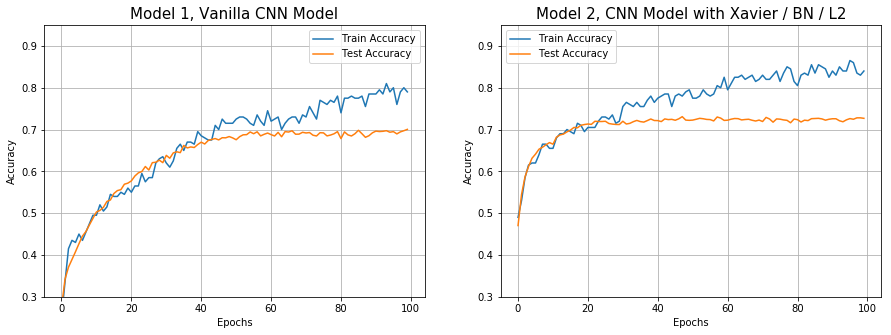

In [46]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(100), history['acc'], label='Train Accuracy')
plt.plot(range(100), history['val_acc'], label='Test Accuracy')
plt.title('Model 1, Vanilla CNN Model', size=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.95])
plt.legend()
plt.grid(True)
plt.subplot(122)
plt.plot(range(100), history2['acc'], label='Train Accuracy')
plt.plot(range(100), history2['val_acc'], label='Test Accuracy')
plt.title('Model 2, CNN Model with Xavier / BN / L2', size=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.95])
plt.legend()
plt.grid(True)
plt.show()

对比两个模型在相同条件下训练准确度和测试准确度的爬升情况，有以下分析：

- **Model#2的收敛速度要远远快于Model#1**：Model#1用了25代训练才抵达60%的测试准确率，而Model#2只用了4代就达到了(曲线弧度更陡)。
- **Model#2的绝对性能要稍好于Model#1**：同样经过100代训练，Model#2的测试准确率比Model#1提升了2%左右。

以上的提升来自于权重初始化方式的改变（从截断正态分布到Xavier初始化）、Batch Normalization 和 L2 Regularization 的引入。

Couple of tips:
- make sure you do Xavier initialization (check that you use the correct parameters depending upon your activation function);
- make sure you are using ReLU (but try Leaky ReLU as well) as your activation function - or possibly ELU;
- implement batch normalization prior to fully connected layers (its often useful in other layers);
- make sure you've implemented dropout;
- test out a different regularization and dropout parameters;
- building an ensemble might net you an additional 1-2% (do this at the end).